# Imports

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path

# Read data

In [146]:
!ls data

data.csv  test.csv  train.csv


In [147]:
df = pd.read_csv("data/data.csv")

In [148]:
df.shape

(150000, 12)

In [149]:
df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


# EDA

In [150]:
df.isnull().sum()

Unnamed: 0                                  0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1221d8390>,
      dtype=object)

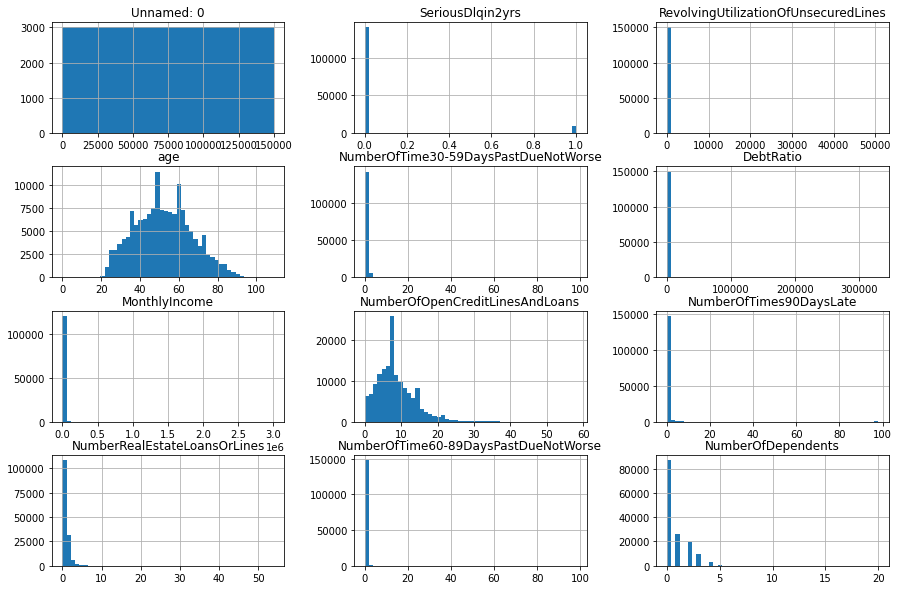

In [151]:
df.hist(bins=50, figsize=(15, 10))

## Unbalanced dataset:

In [152]:
df.SeriousDlqin2yrs.mean()

0.06684

## DebtRatio can either be very small (<1) or very large (>>1):

In [153]:
(df.DebtRatio < 1).mean()

0.7642266666666667

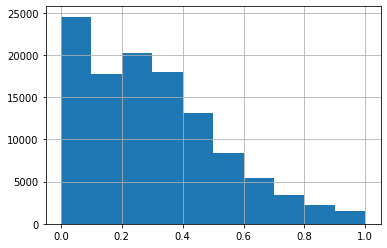

In [154]:
df[df.DebtRatio < 1].DebtRatio.hist()

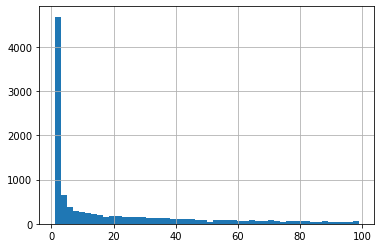

In [155]:
df[(df.DebtRatio > 1) & (df.DebtRatio<100)].DebtRatio.hist(bins=50)

## MonthlyIncome is mostly missing when DebtRatio > 1

In [156]:
df.MonthlyIncome.isnull().mean()

0.19820666666666667

In [157]:
df[(df.DebtRatio<1)].MonthlyIncome.isnull().mean()

0.014149379765165658

In [158]:
df[(df.DebtRatio>1)].MonthlyIncome.isnull().mean()

0.7941486182656459

# Prepare data for ML

In [159]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.base import BaseEstimator, TransformerMixin

In [160]:
from sklearn_pandas import DataFrameMapper

## Imputer

In [161]:
class DFImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy="median", fill_value=None):
        self.imputer = SimpleImputer(strategy=strategy, fill_value=fill_value)
        self.fitted = False
    
    def fit(self, X, y=None):
        self._feature_names = X.columns
        self.imputer.fit(X)
        self.fitted = True
        return self
    
    def transform(self, X):
        assert self.fitted, "Need to cal .fit(X) function first!"
        return pd.DataFrame(self.imputer.transform(X[self._feature_names]), 
                            columns=self._feature_names, index=X.index)
    
    def get_feature_names(self):
        return self._feature_names

In [162]:
transformer = DataFrameMapper([
    (['MonthlyIncome'], DFImputer(strategy="constant", fill_value=-1)),
    (['age'], DFImputer(strategy="median")),
    (['NumberOfDependents'], DFImputer(strategy="median")),
    (['DebtRatio'], DFImputer(strategy="median")),
    (['RevolvingUtilizationOfUnsecuredLines'], DFImputer(strategy="median")),
    (['NumberRealEstateLoansOrLines'], DFImputer(strategy="median")),
    (['NumberOfOpenCreditLinesAndLoans'], DFImputer(strategy="median")),
    (['NumberOfTime30-59DaysPastDueNotWorse'], DFImputer(strategy="median")),
    (['NumberOfTime60-89DaysPastDueNotWorse'], DFImputer(strategy="median")),
    (['NumberOfTimes90DaysLate'], DFImputer(strategy="median")),   
], input_df=True, df_out=True)


## train-test split

In [163]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

TARGET = 'SeriousDlqin2yrs'
X_train = train_df.drop(TARGET, axis=1)
y_train = train_df[TARGET]
X_test = test_df.drop(TARGET, axis=1)
y_test = test_df[TARGET]

## build transformer

In [164]:
transformer.fit(X_train)

X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

# Train model

In [166]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score

In [167]:
model = RandomForestClassifier(n_estimators=50, max_depth=6, max_leaf_nodes=30)
model.fit(X_train, y_train)
y_preds = model.predict(X_test)
y_pred_probas = model.predict_proba(X_test)[:,1]

print("accuracy: ", accuracy_score(y_test, y_preds))
print("roc auc:", roc_auc_score(y_test, y_pred_probas))
print("precision: ", precision_score(y_test, y_preds))
print("recall: ", recall_score(y_test, y_preds))

accuracy:  0.9392666666666667
roc auc: 0.8576604536833953
precision:  0.6288659793814433
recall:  0.12695109261186263


In [168]:
model = RandomForestClassifier(max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200)
model.fit(X_train, y_train)
y_preds = model.predict(X_test)
y_pred_probas = model.predict_proba(X_test)[:,1]

print("accuracy: ", accuracy_score(y_test, y_preds))
print("roc auc:", roc_auc_score(y_test, y_pred_probas))
print("precision: ", precision_score(y_test, y_preds))
print("recall: ", recall_score(y_test, y_preds))

accuracy:  0.9394666666666667
roc auc: 0.8595484231195112
precision:  0.5898305084745763
recall:  0.18106139438085328


In [144]:
print("accuracy: ", accuracy_score(y_test, y_preds))
print("roc auc:", roc_auc_score(y_test, y_pred_probas))
print("precision: ", precision_score(y_test, y_preds))
print("recall: ", recall_score(y_test, y_preds))

accuracy:  0.9398666666666666
roc auc: 0.8593324719995489
precision:  0.6006825938566553
recall:  0.18314255983350677


# Start explainerdashboard

In [173]:
from explainerdashboard.explainers import *
from explainerdashboard.dashboards import *
from explainerdashboard.dashboard_tabs import *

In [174]:
explainer = ClassifierExplainer(model, X_test, y_test, labels=["Not delinquent", "Delinquent"])

Note: shap=='guess' so guessing for RandomForestClassifier shap='tree'...
Note: model_output=='probability', so assuming that raw shap output of RandomForestClassifier is in probability space...
Generating self.shap_explainer = shap.TreeExplainer(model)
Final note: You can always monkeypatch self.shap_explainer if desired...


In [ ]:
db = ExplainerDashboard(explainer).run(8052)

# Start API

In [25]:
import shap
shap_explainer = shap.TreeExplainer(model)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [172]:
import shap
from flask import Flask, request, abort, jsonify
import json

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

flask_app = Flask(__name__)
positive_label = 1
shap_explainer = shap.TreeExplainer(model)
shap_base = shap_explainer.expected_value[1]

@flask_app.route('/predict', methods=['Post'])
def prediction_server_API_call():
    try:
        json_str = request.get_json()
        df = pd.read_json(json_str, orient='records')
    except Exception as e:
        raise e

    if df.empty:
        return(abort(400))
    else:
        features = transformer.transform(df)
        shap_values = np.transpose(shap_explainer.shap_values(features)[positive_label])
        preds = model.predict_proba(features)[:, positive_label]
        response = {}
        response['prediction'] = preds
        response['shap_base'] = shap_base
        response['shap_values'] = {k: v for k, v in zip(features.columns.tolist(), shap_values.tolist())}
        return json.dumps(response, cls=NumpyEncoder)
    
flask_app.run(host='127.0.0.1', port=5002, debug=True, use_reloader=False)

 * Tip: There are .env or .flaskenv files present. Do "pip install python-dotenv" to use them.


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://127.0.0.1:5002/ (Press CTRL+C to quit)
